# Project 242

## Import

In [159]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [161]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


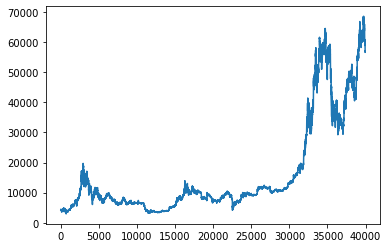

In [162]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [163]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [164]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [165]:
data = data.drop(['VWAP'], axis = 1)

In [166]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [167]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [168]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [169]:
# Add Signal
q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, q_90)
test_data = add_signal(test_data, q_90)

In [170]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (5.0%) | 0 (90.0%) | -1 (5.0%)
Test set: 1 (6.0%) | 0 (88.0%) | -1 (6.0%)


In [171]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [172]:
train = prepare_data_2D_format(train_data)
test = prepare_data_2D_format(test_data, undersample = False)

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [173]:
features = [col for col in train.columns if col not in ['Signal']]
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [174]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.111
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.214
Time:                        12:59:39   Log-Likelihood:                -5365.2
No. Observations:                4458   AIC:                         1.093e+04
Df Residuals:                    4356   BIC:                         1.159e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0097    

We perform feature selection using the p-value

In [175]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.121
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.195
Time:                        12:59:39   Log-Likelihood:                -5365.2
No. Observations:                4458   AIC:                         1.093e+04
Df Residuals:                    4357   BIC:                         1.158e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0102    

In [176]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.132
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.178
Time:                        12:59:40   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.093e+04
Df Residuals:                    4358   BIC:                         1.157e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0111    

In [177]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.143
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.160
Time:                        12:59:41   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.093e+04
Df Residuals:                    4359   BIC:                         1.156e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0106    

In [178]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.143
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.160
Time:                        12:59:42   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.093e+04
Df Residuals:                    4359   BIC:                         1.156e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0106    

In [179]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.155
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.144
Time:                        12:59:46   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.093e+04
Df Residuals:                    4360   BIC:                         1.155e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0108    

In [180]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.167
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        12:59:48   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4361   BIC:                         1.155e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0114    

In [181]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.167
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        12:59:49   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4361   BIC:                         1.155e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0114    

In [182]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.167
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        12:59:50   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4361   BIC:                         1.155e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0114    

In [183]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.167
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        12:59:51   Log-Likelihood:                -5365.3
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4361   BIC:                         1.155e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0114    

In [184]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.191
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.102
Time:                        12:59:51   Log-Likelihood:                -5365.4
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4363   BIC:                         1.153e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0116    

In [185]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.201
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0935
Time:                        12:59:52   Log-Likelihood:                -5365.5
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4364   BIC:                         1.152e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0096    

In [186]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.212
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0843
Time:                        12:59:52   Log-Likelihood:                -5365.6
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4365   BIC:                         1.151e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0095    

In [187]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.224
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0750
Time:                        12:59:53   Log-Likelihood:                -5365.7
No. Observations:                4458   AIC:                         1.092e+04
Df Residuals:                    4366   BIC:                         1.150e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0201    

In [188]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.238
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0653
Time:                        12:59:53   Log-Likelihood:                -5365.7
No. Observations:                4458   AIC:                         1.091e+04
Df Residuals:                    4367   BIC:                         1.150e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0202    

In [189]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.252
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0565
Time:                        12:59:53   Log-Likelihood:                -5365.7
No. Observations:                4458   AIC:                         1.091e+04
Df Residuals:                    4368   BIC:                         1.149e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0204    

In [190]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.264
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0498
Time:                        12:59:54   Log-Likelihood:                -5365.8
No. Observations:                4458   AIC:                         1.091e+04
Df Residuals:                    4369   BIC:                         1.148e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0200    

In [191]:
y_prob = reg.predict(test)

p75 = y_prob.mean() + y_prob.std()/3
p25 = y_prob.mean() - y_prob.std()/3
def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < p25: return -1
    if x > p75: return 1
    return 0
y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]), 
        '-1': len([x for x in y_pred if x == -1]), 
        '0': len([x for x in y_pred if x == 0])}
print(freq)

{'1': 3003, '-1': 3236, '0': 3729}


### 3. Test prediction model

In [196]:
test = test[:]

10

In [193]:
y_test = test['Signal']

TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

### III. Strategy

### 1. Get data ready for backtesting

In [ ]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [ ]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

In [ ]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [ ]:
strat = Strategy(cash=500, fees=0.001)

In [ ]:
strat.run(signal_crop, close_crop, verbose=False)

In [ ]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

In [ ]:
strat.visualize()

### 3. Test performance startegy

In [ ]:
SharpeRatio = SharpeRatio(profit)
MaxDrawback = MaxDrawback(profit)
WinLossRatio = WinLossRatio(profit)
CumulativeProfit = CumulativeProfit(profit)
MeanProfit = MeanProfit(profit)

In [ ]:
models = ['Logistic Regression']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[SharpeRatio, MaxDrawback, WinLossRatio, CumulativeProfit, MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)